In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# compute base forecast no coherent
from statsforecast.models import AutoARIMA
from statsforecast.core import StatsForecast

#obtain hierarchical reconciliation methods and evaluation
from hierarchicalforecast.methods import BottomUp, MinTrace
from hierarchicalforecast.utils import aggregate, HierarchicalPlot
from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.evaluation import HierarchicalEvaluation


In [106]:
df = pd.read_csv('C:\\Users\\IqraImtiaz\\OneDrive - keystonestrategy.com\\Documents\\Moderna\\IQVIA\\iqvia_zip.csv')
df['Date'] = pd.to_datetime(df['Date'])

data = df
data = data.dropna()
data = data.dropna(subset=['PROVIDER_ZIP'])
data["PROVIDER_ZIP"] = data["PROVIDER_ZIP"].astype(str).str.strip()
data = data[data['PROVIDER_ZIP'] != "\"\""]
data["PROVIDER_ZIP"] = data["PROVIDER_ZIP"].str.replace("\"","")
data = data.sort_values(by=['PROVIDER_ZIP', 'Date'])

data['zip'] = data['PROVIDER_ZIP'].astype(str).str.split('.',expand=True)[0]
data['zip'] = np.where(data['zip'].str.len()==3,'00'+data['zip'],np.where(data['zip'].str.len()==4,'0'+data['zip'],data['zip']))
data['zip3'] = data['zip'].str.slice(stop=3)
data = data[['Date','zip3','CLM_CNT']]
data = data.groupby(['zip3','Date']).sum()

# filter on xip codes that have at least 10 data points
data = data.groupby('zip3').filter(lambda x: len(x)>10)
data.reset_index(inplace=True)

grouped_sum = data.groupby('Date')['CLM_CNT'].transform('sum')
data['natl_admins'] = grouped_sum
data['shares'] = (data['CLM_CNT'] / data['natl_admins'])
data['country'] = 'US'
df = data

In [92]:
# Create a complete set of all possible combinations of zip3 and dates
all_dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='W-FRI')
all_zip3 = df['zip3'].unique()
all_country = df['country'].unique()
complete_index = pd.MultiIndex.from_product([all_country,all_zip3, all_dates], names=['country','zip3', 'Date'])

# Reindex the DataFrame to include all combinations, filling missing values with zeros
df_complete = df.set_index(['country','zip3', 'Date']).reindex(complete_index, fill_value=0).reset_index()

In [108]:

# Generate the dataset to match the Australian Domestic Tourism example
data = df_complete[['country','zip3', 'Date', 'CLM_CNT']].rename(columns={'Date': 'ds', 'CLM_CNT': 'y'})

# Define the hierarchical structure (this is similar to the 'spec' you used)
spec = [
    ['country'],
    ['country', 'zip3']
]

# Aggregate data according to the hierarchy
Y_df, S_df, tags = aggregate(data, spec)
Y_df = Y_df.reset_index()


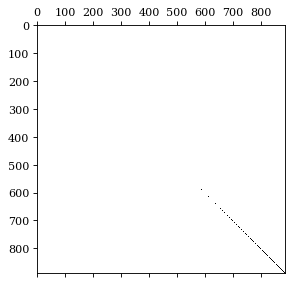

In [95]:
hplot = HierarchicalPlot(S=S_df, tags=tags)
hplot.plot_summing_matrix()


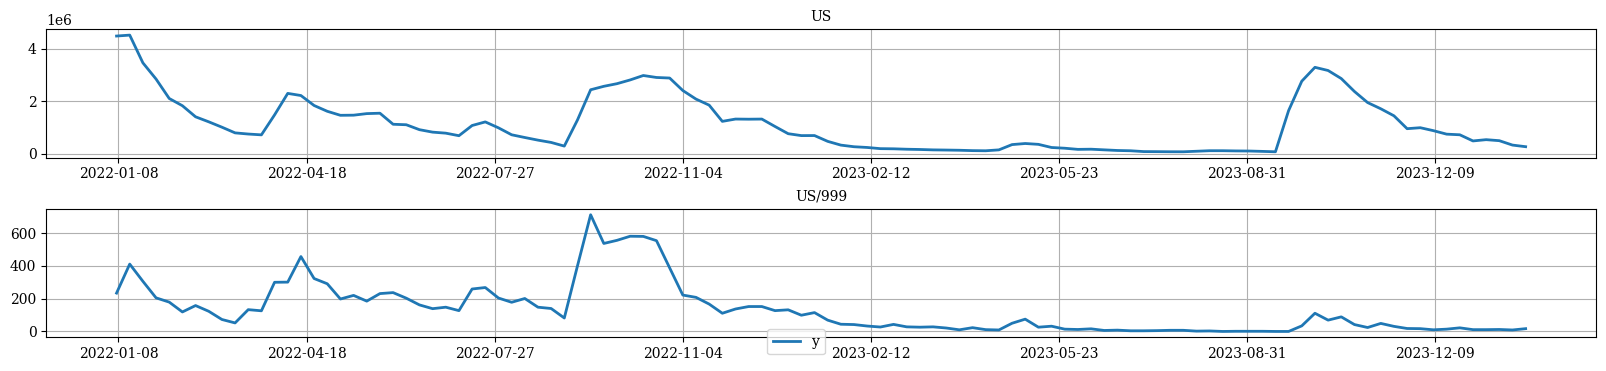

In [96]:
hplot.plot_hierarchically_linked_series(
    bottom_series='US/999',
    Y_df=Y_df.set_index('unique_id')
)


In [97]:

# Train/test split
Y_test_df = Y_df.groupby('unique_id').tail(8)
Y_train_df = Y_df.drop(Y_test_df.index)

Y_test_df = Y_test_df.set_index('unique_id')
Y_train_df = Y_train_df.set_index('unique_id')

# Fit the model with prediction intervals
models = [
    AutoARIMA(season_length=7),
]
fcst = StatsForecast(df=Y_train_df, models=models, freq='W', n_jobs=-1)
h = 8  # Forecast horizon of 8 weeks

c:\Users\IqraImtiaz\.conda\envs\nixtla\lib\site-packages\statsforecast\core.py:474: FutureWarning:

The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method instead, e.g. fit/forecast.

c:\Users\IqraImtiaz\.conda\envs\nixtla\lib\site-packages\statsforecast\core.py:626: FutureWarning:

Passing unique_id as the index is deprecated. Please provide it as a column instead.



In [98]:
Y_hat_df = fcst.forecast(h=h, fitted=True, level=[80, 90])

Y_fitted_df = fcst.forecast_fitted_values()

c:\Users\IqraImtiaz\.conda\envs\nixtla\lib\site-packages\statsforecast\core.py:474: FutureWarning:

The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method instead, e.g. fit/forecast.

c:\Users\IqraImtiaz\.conda\envs\nixtla\lib\site-packages\statsforecast\core.py:492: FutureWarning:

In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.

c:\Users\IqraImtiaz\.conda\envs\nixtla\lib\site-packages\statsforecast\core.py:492: FutureWarning:

In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.



In [99]:
# Reconcile forecasts using MinTrace and BottomUp
reconcilers = [
    BottomUp(),
    MinTrace(method='mint_shrink'),
    MinTrace(method='ols'),
]

hrec = HierarchicalReconciliation(reconcilers=reconcilers)
Y_rec_df = hrec.reconcile(Y_hat_df=Y_hat_df, Y_df=Y_fitted_df, 
                          S=S_df, tags=tags, level=[80, 90])

In [100]:
Y_rec_df.head()


,ds,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-lo-80,AutoARIMA-hi-80,AutoARIMA-hi-90,AutoARIMA/BottomUp,AutoARIMA/BottomUp-lo-90,AutoARIMA/BottomUp-lo-80,AutoARIMA/BottomUp-hi-80,...,AutoARIMA/MinTrace_method-mint_shrink,AutoARIMA/MinTrace_method-mint_shrink-lo-90,AutoARIMA/MinTrace_method-mint_shrink-lo-80,AutoARIMA/MinTrace_method-mint_shrink-hi-80,AutoARIMA/MinTrace_method-mint_shrink-hi-90,AutoARIMA/MinTrace_method-ols,AutoARIMA/MinTrace_method-ols-lo-90,AutoARIMA/MinTrace_method-ols-lo-80,AutoARIMA/MinTrace_method-ols-hi-80,AutoARIMA/MinTrace_method-ols-hi-90
unique_id,,,,,,,,,,,,,,,,,,,,,
US,2023-12-03,1090669.500,595053.625000,704521.250000,1476817.750,1586285.50,993781.2500,930571.773940,944532.975457,1.043030e+06,...,992727.615658,547663.956396,645966.043717,1.339489e+06,1.437791e+06,1.090561e+06,595502.123702,704846.645843,1.476274e+06,1.585619e+06
US,2023-12-10,1149411.250,194523.781250,405431.656250,1893390.875,2104298.75,981282.0625,866820.746482,892102.042872,1.070462e+06,...,979453.660558,210264.231804,380156.616451,1.578751e+06,1.748643e+06,1.149222e+06,195408.740834,406079.382989,1.892365e+06,2.103036e+06
US,2023-12-17,1172062.375,-172949.265625,124126.101562,2219998.500,2517074.00,946433.2500,790001.514726,824552.900310,1.068314e+06,...,943979.655866,-85869.776861,141595.096437,1.746364e+06,1.973829e+06,1.171809e+06,-171690.103020,125051.096841,2.218566e+06,2.515307e+06
US,2023-12-24,1177667.500,-488044.437500,-120135.359375,2475470.250,2843379.50,927819.0000,736827.386525,779012.080500,1.076626e+06,...,925101.982922,-316337.565684,-42138.366600,1.892342e+06,2.166542e+06,1.177386e+06,-486451.882306,-118956.630396,2.473730e+06,2.841225e+06
US,2023-12-31,1177804.750,-757517.000000,-330058.687500,2685668.250,3113126.50,904160.3750,684139.793597,732736.172914,1.075585e+06,...,901184.626163,-517171.048191,-203896.035838,2.006265e+06,2.319540e+06,1.177497e+06,-755647.936577,-328670.419164,2.683664e+06,3.110642e+06


In [101]:
plot_df = pd.concat([Y_df.set_index(['unique_id', 'ds']), 
                     Y_rec_df.set_index('ds', append=True)], axis=1)
plot_df = plot_df.reset_index('ds')


ValueError: operands could not be broadcast together with shapes (0,) (8,) 

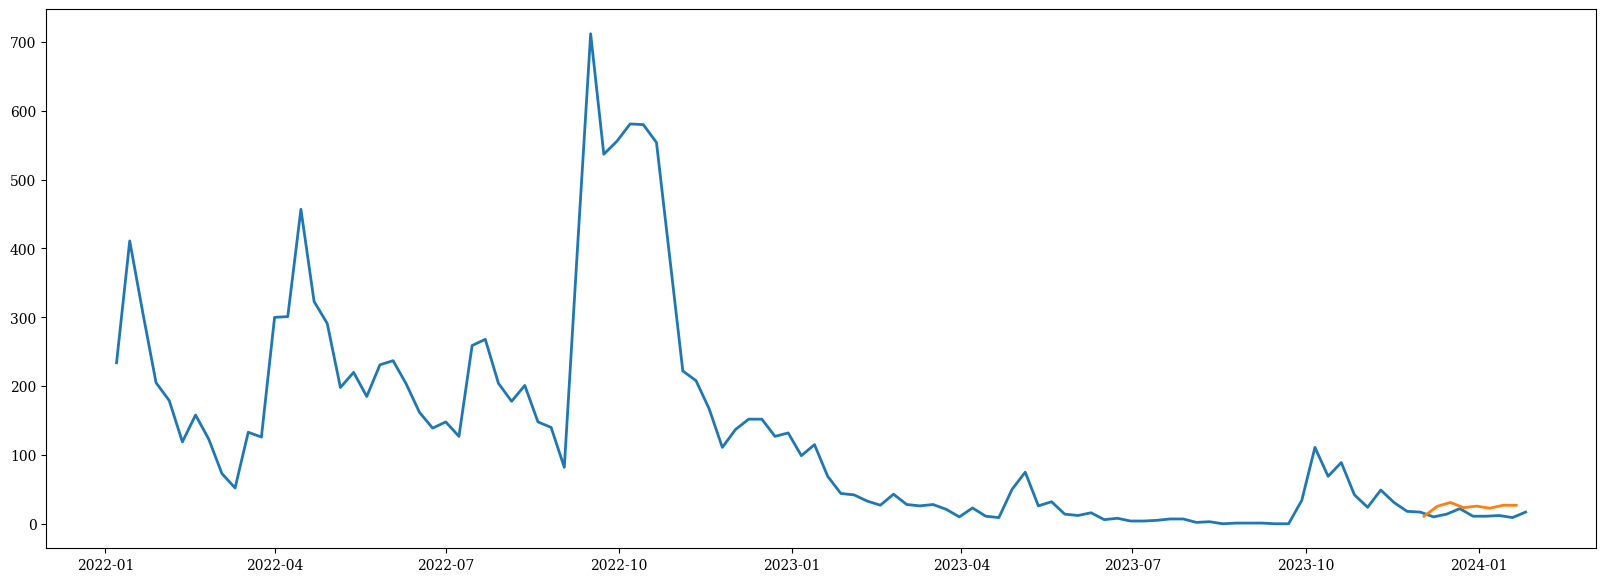

In [102]:
hplot.plot_series(
    series='US/999',
    Y_df=plot_df, 
    models=['y', 'AutoARIMA', 'AutoARIMA/MinTrace_method-ols'],
    level=[80]
)


ValueError: operands could not be broadcast together with shapes (0,) (8,) 

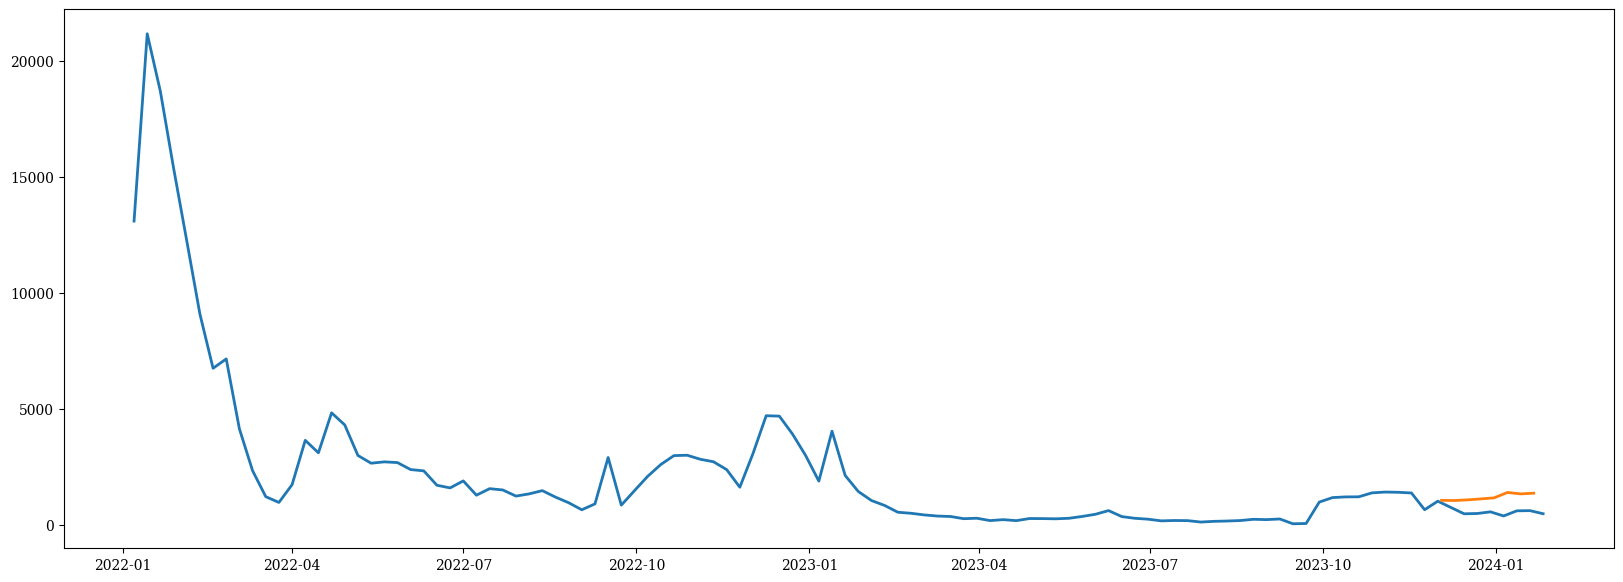

In [104]:
# Since we are plotting a bottom time series
# the probabilistic and mean forecasts
# are the same
hplot.plot_series(
    series='US/006',
    Y_df=plot_df, 
    models=['y', 'AutoARIMA', 'AutoARIMA/BottomUp'],
    level=[80]
)


In [105]:
def rmse(y, y_hat):
    return np.mean(np.sqrt(np.mean((y-y_hat)**2, axis=1)))

def mase(y, y_hat, y_insample, seasonality=7):
    errors = np.mean(np.abs(y - y_hat), axis=1)
    scale = np.mean(np.abs(y_insample[:, seasonality:] - y_insample[:, :-seasonality]), axis=1)
    return np.mean(errors / scale)

def mape(y, y_hat):
    m = np.mean(np.abs((y - y_hat) / (y + np.finfo(float).eps)), axis=1)
    return np.mean(m * 100)

eval_tags = {}
eval_tags['total'] = tags['country']
eval_tags['zip3'] = tags['country/zip3']
eval_tags['All'] = np.concatenate(list(tags.values()))

evaluator = HierarchicalEvaluation(evaluators=[rmse, mase, mape])
evaluation = evaluator.evaluate(
        Y_hat_df=Y_rec_df, Y_test_df=Y_test_df,
        tags=eval_tags, Y_df=Y_train_df
)
evaluation = evaluation.drop('Overall')
#evaluation.columns = ['Base', 'BottomUp', 'MinTrace(mint_shrink)', 'MinTrace(ols)']
evaluation = evaluation.applymap('{:.2f}'.format)
evaluation

C:\Users\IqraImtiaz\AppData\Local\Temp\ipykernel_15456\2689934852.py:23: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.

C:\Users\IqraImtiaz\AppData\Local\Temp\ipykernel_15456\2689934852.py:25: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



AutoARIMA        AutoARIMA-lo-90  \
level metric                                                
total rmse               643332.20             1180119.37   
      mase                    0.67                   1.19   
      mape                  142.36                 257.75   
zip3  rmse                  481.00                1701.26   
      mase                    0.51                   1.54   
      mape    27699729814254168.00  309553028391075072.00   
All   rmse                 1204.12                3026.81   
      mase                    0.51                   1.54   
      mape    27668571513000788.00  309204824759589120.00   

                    AutoARIMA-lo-80        AutoARIMA-hi-80  \
level metric                                                 
total rmse                778947.98             2059236.95   
      mase                     0.78                   2.11   
      mape                   169.38                 454.09   
zip3  rmse                  1243.13                2096.27   
      mase                     1.12                   2.01   
      mape    235063590267504224.00  290460860492518528.00   
All   rmse                  2117.94                4410.26   
      mase                     1.12                   2.01   
      mape    234799176780139200.00  290134132865417856.00   

                    AutoARIMA-hi-90    AutoARIMA/BottomUp  \
level metric                                                
total rmse               2460991.94             391419.95   
      mase                     2.52                  0.40   
      mape                   542.47                 86.78   
zip3  rmse                  2564.08                481.00   
      mase                     2.44                  0.51   
      mape    364950300342933568.00  27699729814254168.00   
All   rmse                  5329.46                920.75   
      mase                     2.44                  0.51   
      mape    364539782569769408.00  27668571513000788.00   

             AutoARIMA/BottomUp-lo-90 AutoARIMA/BottomUp-lo-80  \
level metric                                                     
total rmse                  188962.16                233122.94   
      mase                       0.19                     0.23   
      mape                      41.45                    51.46   
zip3  rmse                    1701.26                  1243.13   
      mase                       1.54                     1.12   
      mape      309553033926397184.00    235063593226008864.00   
All   rmse                    1911.90                  1503.97   
      mase                       1.54                     1.12   
      mape      309204830288684800.00    234799179735315968.00   

             AutoARIMA/BottomUp-hi-80 AutoARIMA/BottomUp-hi-90  \
level metric                                                     
total rmse                  551062.25                596414.02   
      mase                       0.56                     0.61   
      mape                     122.10                   132.11   
zip3  rmse                    2096.27                  2564.08   
      mase                       2.01                     2.44   
      mape      290460864171515136.00    364950304871903616.00   
All   rmse                    2713.77                  3232.07   
      mase                       2.00                     2.44   
      mape      290134136540276096.00    364539787093645056.00   

             AutoARIMA/MinTrace_method-mint_shrink  \
level metric                                         
total rmse                               388694.91   
      mase                                    0.40   
      mape                                   86.17   
zip3  rmse                                  479.99   
      mase                                    0.54   
      mape                    37894491738942944.00   
All   rmse                                  916.68   
      mase                                    0.54   
    